In [ ]:
print("Setting up colab environment")
!pip install skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
import os
import statsmodels.tsa.api as smtsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import math as math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import seaborn as sns 
import itertools as it
import torch
from torch.autograd import Variable
import time
%matplotlib inline 

Setting up colab environment
     |████████████████████████████████| 155 kB 25.7 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def custom_data_prep(data, window):
    x = []
    y = []

    for i in range(len(data)-window-1):
        _x = data[i:(i+window)]
        _y = data[i+window]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [ ]:
crime_data_df = pd.read_csv("UKViolent_Crimes.csv", index_col=0, parse_dates=True, squeeze=True)
print(type(crime_data_df))
crime_data_df = crime_data_df.iloc[::-1]
crime_data_df

<class 'pandas.core.frame.DataFrame'>


,Month,Total
0,2013-05,57031
1,2013-06,57815
2,2013-07,64962
3,2013-08,61607
4,2013-09,56964
...,...,...
92,2021-01,141414
93,2021-02,135101
94,2021-03,166668
95,2021-04,153789


In [ ]:
month = crime_data_df.Month.astype('datetime64[ns]')
crime_data_df_idxd = crime_data_df.drop(columns='Month')
crime_data_df_2 = crime_data_df_idxd.set_index(pd.to_datetime(month))
crime_data_df_2.head()


,Total
Month,
2013-05-01,57031
2013-06-01,57815
2013-07-01,64962
2013-08-01,61607
2013-09-01,56964


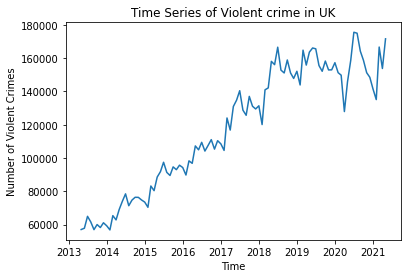

In [ ]:
plt.plot(crime_data_df_2)
plt.title("Time Series of Violent crime in UK")
plt.xlabel("Time")
plt.ylabel("Number of Violent Crimes")
plt.show()

Rescale the data for use in LSTM as convergence can be reached quicker.

In [ ]:
#Scale the values between 0-1 as deep learning models can better interpret data.
scaler = skp.MinMaxScaler()
x_vals_scaled = scaler.fit_transform(crime_data_df_2.values)

window = 12

x, y = custom_data_prep(x_vals_scaled, window)

#split the data into train, validation and test splits using pytorch dataloader and Tensor dataset.

train_size = int(len(y) * 0.55)
val_size = int(train_size+13)
test_size = int(val_size+25)


train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=46)

data_batch, target_batch = next(iter(trainloader))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0])
print('Target:', target_batch[0])

val_x = Variable(torch.Tensor(np.array(x[train_size+1:val_size])))
val_y = Variable(torch.Tensor(np.array(y[train_size+1:val_size])))

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=12)

val_data_batch, val_target_batch = next(iter(valloader))
print(val_data_batch.size())
print(val_target_batch.size())
print('Training Window:', val_data_batch[0])
print('Target:', val_target_batch[0])

test_x = Variable(torch.Tensor(np.array(x[val_size+1:test_size])))
test_y = Variable(torch.Tensor(np.array(y[val_size+1:test_size])))

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=24)

test_data_batch, test_target_batch = next(iter(testloader))
print(test_data_batch.size())
print(test_target_batch.size())
print('Training Window:', test_data_batch[0])
print('Target:', test_target_batch[0])

torch.Size([46, 12, 1])
torch.Size([46, 1])
Training Window: tensor([[0.0020],
        [0.0086],
        [0.0687],
        [0.0405],
        [0.0014],
        [0.0271],
        [0.0121],
        [0.0361],
        [0.0210],
        [0.0000],
        [0.0722],
        [0.0507]])
Target: tensor([0.1033])
torch.Size([12, 12, 1])
torch.Size([12, 1])
Training Window: tensor([[0.5052],
        [0.6244],
        [0.6564],
        [0.7042],
        [0.6058],
        [0.5799],
        [0.6755],
        [0.6256],
        [0.6119],
        [0.6279],
        [0.5330],
        [0.7087]])
Target: tensor([0.7184])
torch.Size([24, 12, 1])
torch.Size([24, 1])
Training Window: tensor([[0.8526],
        [0.8361],
        [0.9244],
        [0.8086],
        [0.7940],
        [0.8597],
        [0.7943],
        [0.7664],
        [0.8026],
        [0.7333],
        [0.9094],
        [0.8339]])
Target: tensor([0.8995])


Build Basic LSTM Class

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        #num_classes = output dimension, num_layers = amount of LSTM layers stacked, input_size = input data dimension (window size), hidden_size = hidden neurons per layer.
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = window
        #PyTorch LSTM module
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #PyTorch linear layer for output
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    #forward pass of cell and hidden state
    def forward(self, x):
      #hidden state output
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        #cell output
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
input_size = 1
hidden_size = 12
num_layers = 1
output_size = 1

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)


In [ ]:
start = time.time()

epochs = 150
train_loss = []
val_loss = []

for i in range(epochs):
  lstm_model.train()
  epoch_loss = 0.0
  for x_train,y_train in trainloader:
      
    optim.zero_grad()  

    y_pred = lstm_model(x_train)

    single_loss = loss(y_pred, y_train)
    single_loss.backward()
    optim.step()

    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {single_loss.item():10.8f}')

  lstm_model.eval()
  for x_val,y_val in valloader:

    optim.zero_grad()  

    y_pred = lstm_model(x_val)

    single_loss = loss(y_pred, y_val)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}validation loss: {single_loss.item():10.8f}')

end = time.time()

epoch:   1 train loss: 0.35158965
epoch:   1validation loss: 0.99520731
epoch:  26 train loss: 0.04986501
epoch:  26validation loss: 0.02153420
epoch:  51 train loss: 0.00347617
epoch:  51validation loss: 0.00783897
epoch:  76 train loss: 0.00301546
epoch:  76validation loss: 0.00545231
epoch: 101 train loss: 0.00312550
epoch: 101validation loss: 0.00512347
epoch: 126 train loss: 0.00312601
epoch: 126validation loss: 0.00498768


In [ ]:
print("Time taken to train:", end - start,"s")

Time taken to train: 1.2137601375579834 s


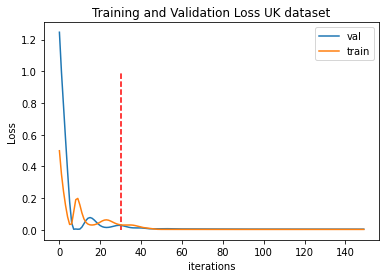

In [ ]:
fig, ax = plt.subplots()
ax.plot(val_loss,label="val")
ax.plot(train_loss,label="train")
ax.vlines(30, 0, 1, linestyles='dashed', colors='red')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.title("Training and Validation Loss UK dataset")
plt.legend()
plt.show()

In [ ]:
lstm_model.eval()
for x_test,y_test in testloader:
  
  y_test_pred = lstm_model(x_test)
  
print(y_test_pred.shape)

torch.Size([24, 1])


(24, 1)
[[157704.8 ]
 [159280.95]
 [160382.66]
 [160818.11]
 [159269.02]
 [158219.62]
 [158948.86]
 [158035.05]
 [157773.4 ]
 [158443.2 ]
 [157443.27]
 [156712.34]
 [151800.73]
 [153397.06]
 [155922.52]
 [160126.5 ]
 [161840.8 ]
 [160953.77]
 [159996.48]
 [158314.17]
 [157124.19]
 [155013.39]
 [152710.7 ]
 [157972.7 ]]


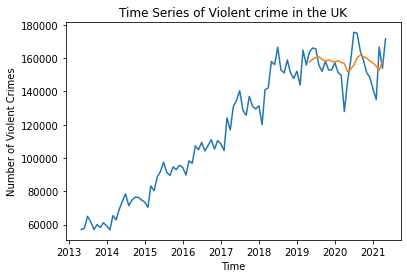

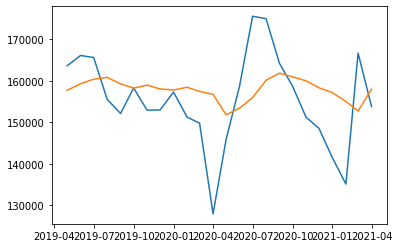

In [ ]:

data_predict = y_test_pred.data.numpy()
print(data_predict.shape)


predictions_rescaled = scaler.inverse_transform(data_predict)
print(predictions_rescaled)

df = pd.DataFrame(predictions_rescaled, index=crime_data_df_2.index[72:96])

fig, ax = plt.subplots()
ax.plot(crime_data_df_2)
ax.plot(df)
plt.title("Time Series of Violent crime in the UK")
plt.xlabel("Time")
plt.ylabel("Number of Violent Crimes")
plt.show()

fig, ax = plt.subplots()
ax.plot(crime_data_df_2.index[72:96], crime_data_df_2['Total'][72:96])
plt.plot(df)
plt.show()

In [ ]:
test_rescaled = crime_data_df_2['Total'][72:96]

rmse = skm.mean_squared_error(test_rescaled, predictions_rescaled, squared = False)
print("Mean squared error for 12 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_rescaled, predictions_rescaled)
print("Mean absolute percentage error for 12 forecast steps:", mape)

Mean squared error for 12 forecast steps: 10991.187095466423
Mean absolute percentage error for 12 forecast steps: 0.05759807829990282


In [ ]:

fut_test_x = Variable(torch.Tensor(np.array(x[72:test_size])))
pred = []
pred.append(fut_test_x)


def predict(num_prediction, model):
  for i in range(num_prediction):
    out = model(pred[i])
    #out = torch.reshape(out,(1,12,1))
    pred.append(out)

  return pred

predict(2,lstm_model)

RuntimeError: ignored

In [ ]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)

In [ ]:
lstm_hyper_net = NeuralNetRegressor(
        module=lstm_model, max_epochs=60,
        optimizer=torch.optim.Adam,
        criterion=loss,
        lr=0.01, verbose=1
    )

In [ ]:
params = {
    'lr': [0.001, 0.01, 0.1, 0.005, 0.05, 0.5],
    'module__hidden_size': [2,4,6,8,10,12,14,16,18,20],
    'module__num_classes': [1],
    'module__input_size': [1],
    'module__num_layers': [1] 
    }


In [ ]:
gs = GridSearchCV(
        lstm_hyper_net, params, refit=False, scoring='neg_mean_squared_error', verbose=1, cv=cv, error_score="raise"
    )

In [ ]:
start = time.time()
for i, data in enumerate(trainloader):
  x,y = data
  outputs = gs.fit(x, y)
end = time.time()

In [ ]:
print("Time taken to train hyperparamters:", end - start,"s")

Time taken to train hyperparamters: 239.08023118972778 s


In [ ]:
print('SEARCH COMPLETE')
print(gs.cv_results_)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

SEARCH COMPLETE
{'mean_fit_time': array([0.71704769, 0.67678857, 0.68489876, 0.69675231, 0.73038073,
       0.76540647, 0.77938476, 0.76434407, 0.78853741, 0.77761397,
       0.76324091, 0.72087846, 0.80384345, 0.82065206, 0.84392433,
       0.76197462, 0.78591971, 0.78377938, 0.77012262, 0.85514169,
       0.75203648, 0.79848328, 0.75783219, 0.79367704, 0.82751164,
       0.84284539, 0.85600562, 0.85164294, 0.83288016, 0.84428663,
       0.79573145, 0.79141474, 0.76742601, 0.7610199 , 0.80962696,
       0.78797617, 0.83812647, 0.82345958, 0.77579889, 0.82629895,
       0.77922354, 0.74835472, 0.75093164, 0.79944968, 0.80886459,
       0.83285065, 0.84040394, 0.80078316, 0.77645025, 0.77541747,
       0.78951187, 0.81308832, 0.80481362, 0.7587388 , 0.79056883,
       0.82205868, 0.8393168 , 0.8080122 , 0.85505958, 0.89779115]), 'std_fit_time': array([0.05517138, 0.03195919, 0.01972416, 0.00869654, 0.01500928,
       0.0304043 , 0.01351794, 0.02692882, 0.0377422 , 0.02282074,
       0.0

Using Grid Search hyperparamters for optimised LSTM model


In [ ]:

input_size = 1
hidden_size = gs.best_params_['module__hidden_size']
num_layers = 1
output_size = 1

lstm_hyper_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_hyper_model.parameters(), lr=gs.best_params_['lr'])
print(lstm_hyper_model)

LSTM(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


Hyperparamter training 

In [ ]:
start = time.time()

epochs = 150
train_loss = []
val_loss = []

for i in range(epochs):
  lstm_hyper_model.train()
  epoch_loss = 0.0
  for x_train,y_train in trainloader:
      
    optim.zero_grad()  

    y_pred = lstm_hyper_model(x_train)

    single_loss = loss(y_pred, y_train)
    single_loss.backward()
    optim.step()

    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {single_loss.item():10.8f}')

  lstm_hyper_model.eval()
  for x_val,y_val in valloader:

    optim.zero_grad()  

    y_pred = lstm_hyper_model(x_val)

    single_loss = loss(y_pred, y_val)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}validation loss: {single_loss.item():10.8f}')

end = time.time()

epoch:   1 train loss: 0.40367204
epoch:   1validation loss: 0.00619720
epoch:  26 train loss: 0.00437476
epoch:  26validation loss: 0.00678266
epoch:  51 train loss: 0.00321035
epoch:  51validation loss: 0.00479882
epoch:  76 train loss: 0.00309668
epoch:  76validation loss: 0.00475775
epoch: 101 train loss: 0.00311572
epoch: 101validation loss: 0.00462969
epoch: 126 train loss: 0.00309046
epoch: 126validation loss: 0.00447148


In [ ]:
print('Optmised model training time:', end - start, 's')

Optmised model training time: 1.1788480281829834 s


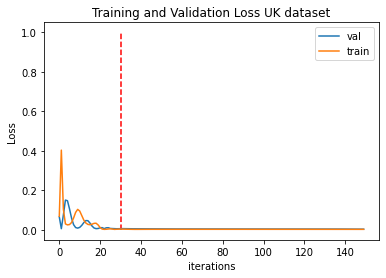

In [ ]:
fig, ax = plt.subplots()
ax.plot(val_loss,label="val")
ax.plot(train_loss,label="train")
ax.vlines(30, 0, 1, linestyles='dashed', colors='red')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.title("Training and Validation Loss UK dataset")
plt.legend()
plt.show()

In [ ]:
lstm_hyper_model.eval()
for x_test,y_test in testloader:
  
  y_test_pred = lstm_hyper_model(x_test)
  
print(y_test_pred)

tensor([[0.8801],
        [0.9053],
        [0.9145],
        [0.9039],
        [0.8511],
        [0.8054],
        [0.8109],
        [0.8101],
        [0.8242],
        [0.8553],
        [0.8500],
        [0.8350],
        [0.7366],
        [0.7555],
        [0.8331],
        [0.9522],
        [0.9962],
        [0.9496],
        [0.8727],
        [0.7802],
        [0.7256],
        [0.7022],
        [0.6980],
        [0.8463]], grad_fn=<AddmmBackward0>)


(24, 1)
[[161318.64]
 [164319.77]
 [165412.72]
 [164149.16]
 [157882.08]
 [152449.47]
 [153104.8 ]
 [153004.5 ]
 [154677.98]
 [158382.19]
 [157748.3 ]
 [155962.25]
 [144283.1 ]
 [146521.73]
 [155735.95]
 [169889.94]
 [175111.95]
 [169570.72]
 [160439.84]
 [149461.11]
 [142974.11]
 [140190.5 ]
 [139694.08]
 [157307.58]]


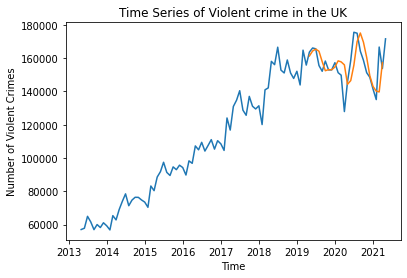

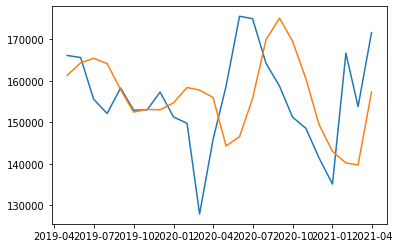

In [ ]:

data_predict = y_test_pred.data.numpy()
print(data_predict.shape)

predictions_rescaled = scaler.inverse_transform(data_predict)
print(predictions_rescaled)

df = pd.DataFrame(predictions_rescaled, index=crime_data_df_2.index[72:96])

fig, ax = plt.subplots()
ax.plot(crime_data_df_2)
ax.plot(df)
plt.title("Time Series of Violent crime in the UK")
plt.xlabel("Time")
plt.ylabel("Number of Violent Crimes")
plt.show()

fig, ax = plt.subplots()
ax.plot(crime_data_df_2.index[72:96], crime_data_df_2['Total'][72:96])
plt.plot(df)
plt.show()

In [ ]:
test_rescaled = crime_data_df_2['Total'][72:96]

rmse = skm.mean_squared_error(test_rescaled, predictions_rescaled, squared = False)
print("Mean squared error for 12 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_rescaled, predictions_rescaled)
print("Mean absolute percentage error for 12 forecast steps:", mape)

Mean squared error for 12 forecast steps: 10641.791804814957
Mean absolute percentage error for 12 forecast steps: 0.048262823068012474
